In [1]:
from datetime import date
print(date.today())

2023-06-19


# 3. Integration

Objectives: 

1. List possible sources of differences between single-cell datasets
1. Explain why these differences may lead to problems, i.e. in cell type detection or diff. gene expression
1. List the main strategies for dataset integration
    - global models
    - linear embedding models
    - graph-based methods
    - deep learning
1. Find and parse recent benchmarking publications
1. Explain their preference for a benchmarking strategy/method
1. Run integration method on dataset
1. Demonstrate that integration achieved the intended effect

### 3.1 Why is integration needed?

- have students run without integration and see what happens
- construct possible scenarios/experimental designs that could lead to batch effects
- take away lessons for experimental design. Are there ways to prevent batch effects?

### 3.2 How do we integrate?

- work on gold standard (HCA or MCA)
- run different tools (at least in Python ecosystem):
    - UMI downsampling
    - BBKNN
    - MNN
    - pyHarmony
    - pyLiger
    - scVI
    - scANVI

What do we learn from the integrated data that we couldn't learn before?

### 3.3 How do we evaluate if it worked?

- discuss with students: What would we expect? How would we measure it?
- use [`scib`](https://github.com/theislab/scib) from [Luecken _et al._
  2021](https://www.nature.com/articles/s41592-021-01336-8), [PMD](https://bitbucket.org/scottyler892/pyminer_norm/src)
  from [Tyler _et al._ 2021](https://www.biorxiv.org/content/10.1101/2021.11.15.468733v1.full)
- see how homogeneous each cluster is before/after
- HVG conservation before/after
- run Alison's method (z-scores) and UMI downsampling as baseline integration
- compare to "no integration at all"
- positive/negative controls?

In [2]:
import glob
import scanpy as sc
import anndata as ad

import matplotlib.pyplot as plt

In [3]:
patients = {}
out = "/Users/npapadop/Documents/teaching/2023/advanced_scRNAseq/data/human_pancreas/patients"
for patient in glob.glob(out + "/*"):
    patient_id = patient.split("_")[-1].split(".")[0]
    patients[patient_id] = sc.read_h5ad(patient)

# No integration

In [4]:
naive = ad.concat(patients.values(), join="outer", label="patient")
# Let's transfer the metadata from a previous file:
naive.var = patients["scRSq01"].var[["gene_names", "mitochondrial", "ribosomal"]].copy()
sc.pp.calculate_qc_metrics(naive, inplace=True)

In [5]:
sc.pp.normalize_per_cell(naive, counts_per_cell_after=None)
sc.pp.log1p(naive)
sc.pp.highly_variable_genes(naive, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.pca(naive, n_comps=50, use_highly_variable=True, chunked=True)
sc.pp.neighbors(naive, n_neighbors=10, n_pcs=40, metric="cosine")
sc.tl.umap(naive, min_dist=0.2)

/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packag

/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No d

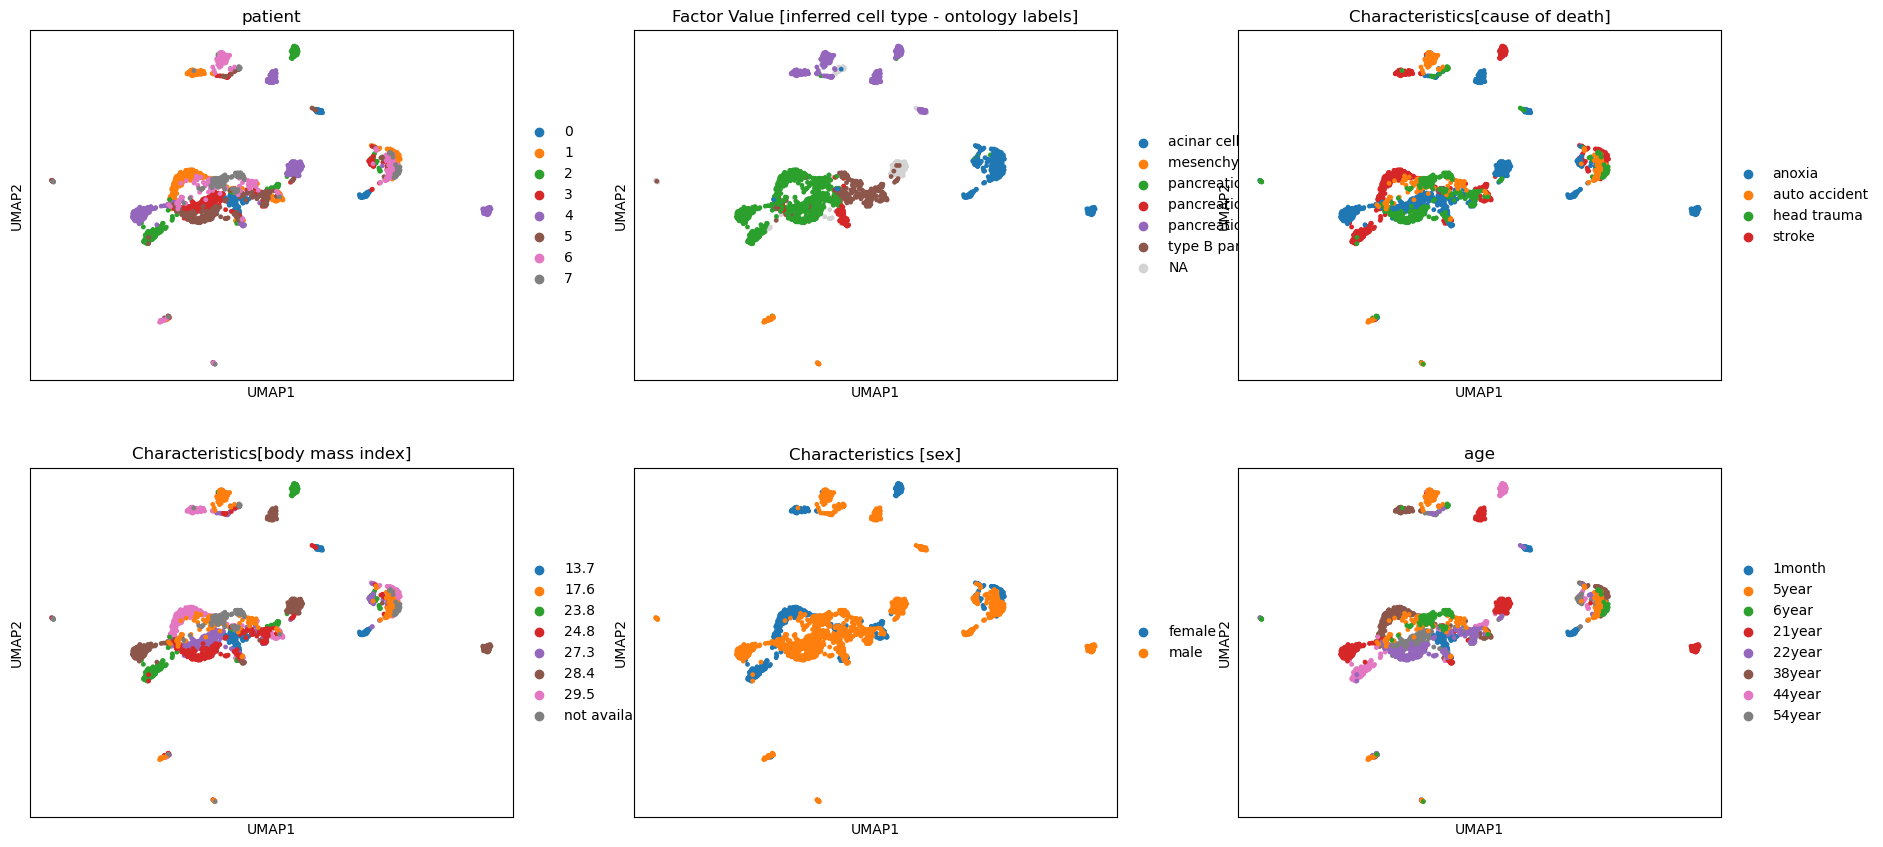

In [6]:
sc.pl.umap(naive, color=["patient",
                         "Factor Value [inferred cell type - ontology labels]",
                         "Characteristics[cause of death]",
                         "Characteristics[body mass index]",
                         "Characteristics [sex]",
                         "age"], ncols=3);

# Downsampling

In [7]:
downsampling = ad.concat(patients.values(), join="outer", label="patient")
# Let's transfer the metadata from a previous file:
downsampling.var = patients["scRSq01"].var[["gene_names", "mitochondrial", "ribosomal"]].copy()
sc.pp.calculate_qc_metrics(downsampling, inplace=True)

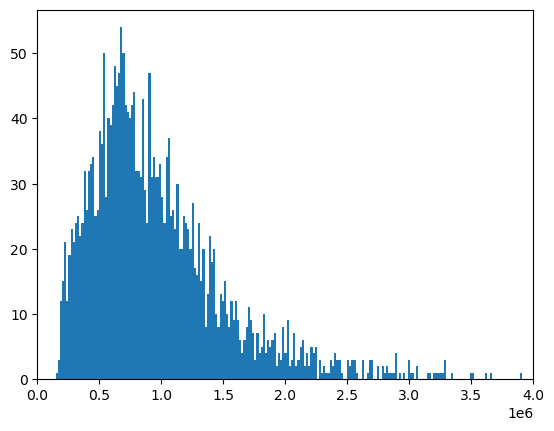

In [8]:
fig, ax = plt.subplots()
ax.hist(downsampling.obs["total_counts"], bins=500)
ax.set_xbound(0, 4e6)

In [9]:
sc.pp.downsample_counts(downsampling, total_counts=1e6)

In [10]:
sc.pp.normalize_per_cell(downsampling, counts_per_cell_after=None)
sc.pp.log1p(downsampling)
sc.pp.highly_variable_genes(downsampling, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.pca(downsampling, n_comps=50, use_highly_variable=True, chunked=True)
sc.pp.neighbors(downsampling, n_neighbors=10, n_pcs=40, metric="cosine")
sc.tl.umap(downsampling, min_dist=0.2)

/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax

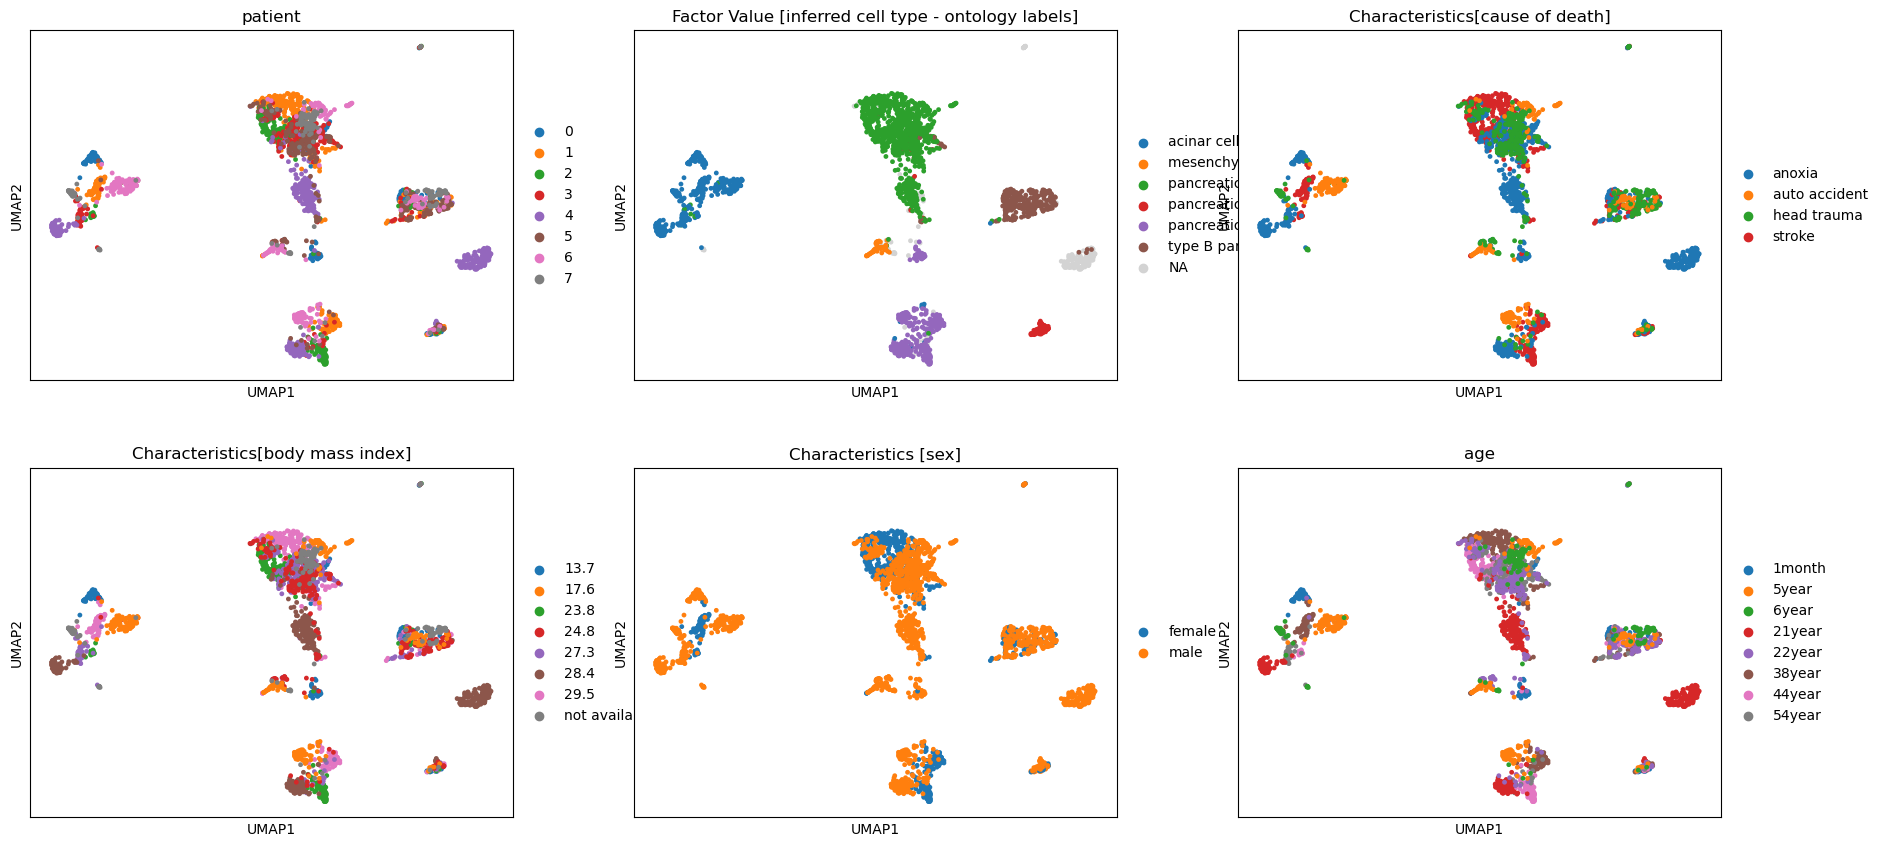

In [11]:
sc.pl.umap(downsampling, color=["patient",
                         "Factor Value [inferred cell type - ontology labels]",
                         "Characteristics[cause of death]",
                         "Characteristics[body mass index]",
                         "Characteristics [sex]",
                         "age"], ncols=3);

# BBKNN

In [12]:
bbknn = ad.concat(patients.values(), join="outer", label="patient")
# Let's transfer the metadata from a previous file:
bbknn.var = patients["scRSq01"].var[["gene_names", "mitochondrial", "ribosomal"]].copy()
sc.pp.calculate_qc_metrics(bbknn, inplace=True)

In [13]:
sc.pp.normalize_per_cell(bbknn, counts_per_cell_after=None)
sc.pp.log1p(bbknn)
sc.pp.highly_variable_genes(bbknn, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.pca(bbknn, n_comps=50, use_highly_variable=True, chunked=True)

In [14]:
sc.external.pp.bbknn(bbknn, batch_key="patient")

In [15]:
sc.tl.umap(bbknn, min_dist=0.2)

/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax

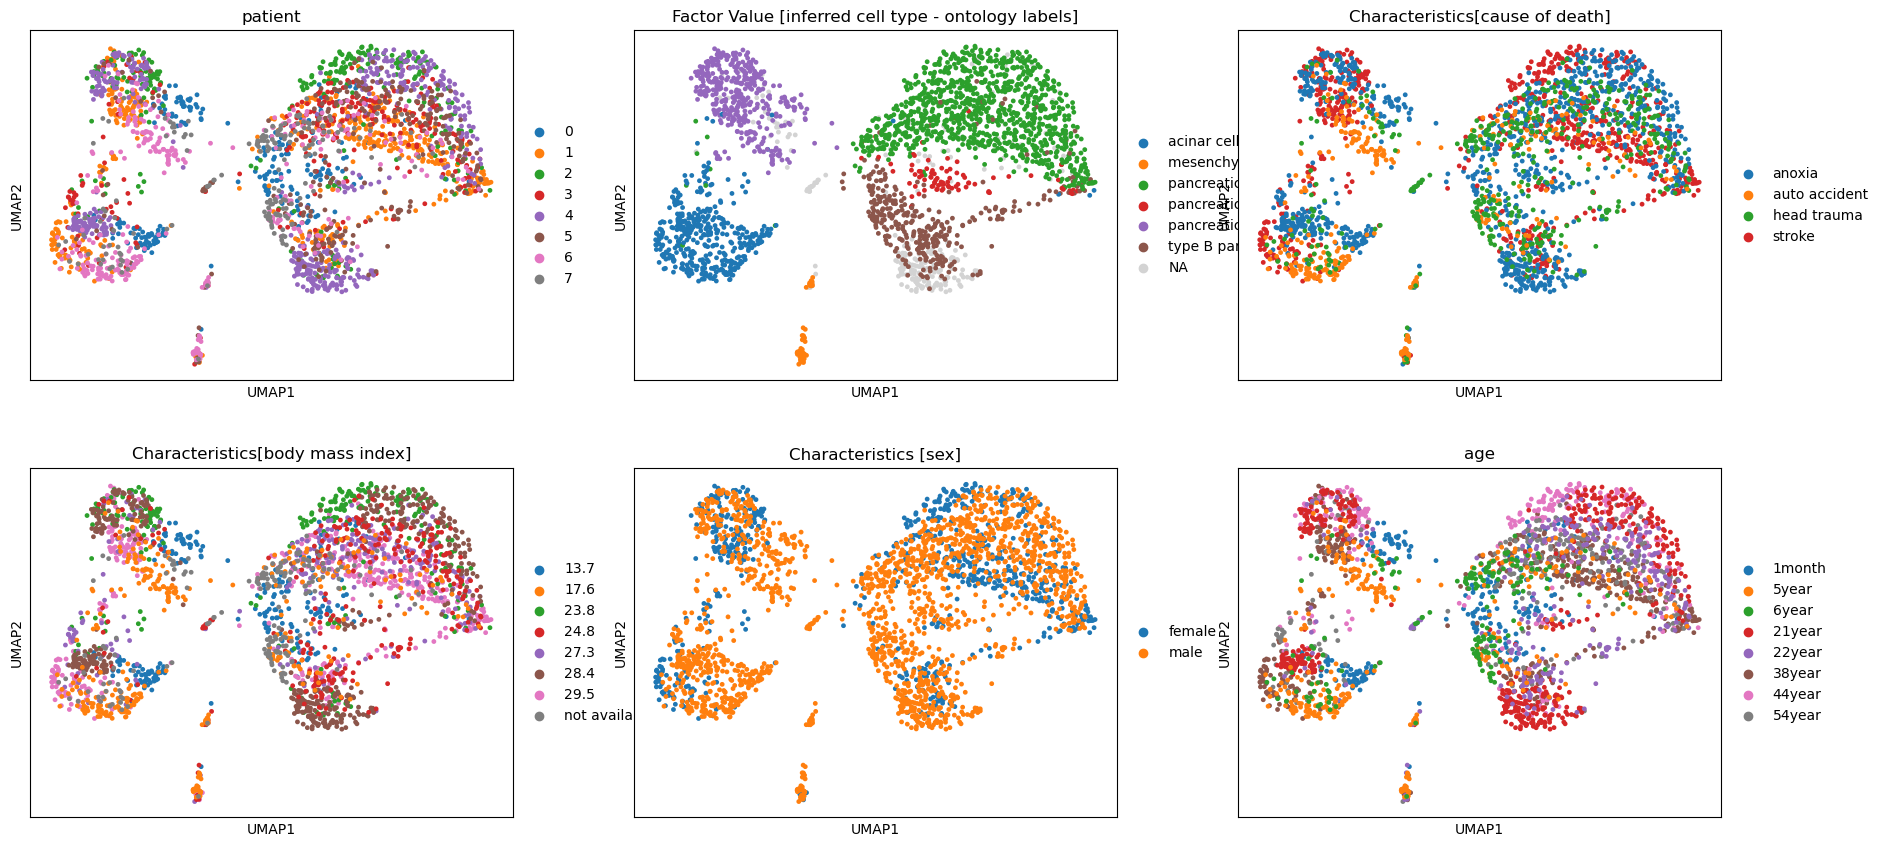

In [16]:
sc.pl.umap(bbknn, color=["patient",
                         "Factor Value [inferred cell type - ontology labels]",
                         "Characteristics[cause of death]",
                         "Characteristics[body mass index]",
                         "Characteristics [sex]",
                         "age"], ncols=3);

# Harmony

In [17]:
harmony = ad.concat(patients.values(), join="outer", label="patient")
# Let's transfer the metadata from a previous file:
harmony.var = patients["scRSq01"].var[["gene_names", "mitochondrial", "ribosomal"]].copy()
sc.pp.calculate_qc_metrics(harmony, inplace=True)

In [18]:
sc.pp.normalize_per_cell(harmony, counts_per_cell_after=None)
sc.pp.log1p(harmony)
sc.pp.highly_variable_genes(harmony, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.pca(harmony, n_comps=50, use_highly_variable=True, chunked=True)

In [19]:
sc.external.pp.harmony_integrate(harmony, "patient")

2023-06-19 09:09:44,523 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-06-19 09:09:45,133 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-06-19 09:09:45,148 - harmonypy - INFO - Iteration 1 of 10
2023-06-19 09:09:45,419 - harmonypy - INFO - Iteration 2 of 10
2023-06-19 09:09:45,834 - harmonypy - INFO - Iteration 3 of 10
2023-06-19 09:09:46,104 - harmonypy - INFO - Iteration 4 of 10
2023-06-19 09:09:46,373 - harmonypy - INFO - Iteration 5 of 10
2023-06-19 09:09:46,591 - harmonypy - INFO - Iteration 6 of 10
2023-06-19 09:09:46,824 - harmonypy - INFO - Iteration 7 of 10
2023-06-19 09:09:46,979 - harmonypy - INFO - Iteration 8 of 10
2023-06-19 09:09:47,122 - harmonypy - INFO - Iteration 9 of 10
2023-06-19 09:09:47,268 - harmonypy - INFO - Iteration 10 of 10
2023-06-19 09:09:47,412 - harmonypy - INFO - Stopped before convergence


In [20]:
sc.pp.neighbors(harmony, use_rep="X_pca_harmony")
sc.tl.umap(harmony, min_dist=0.2)

/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax

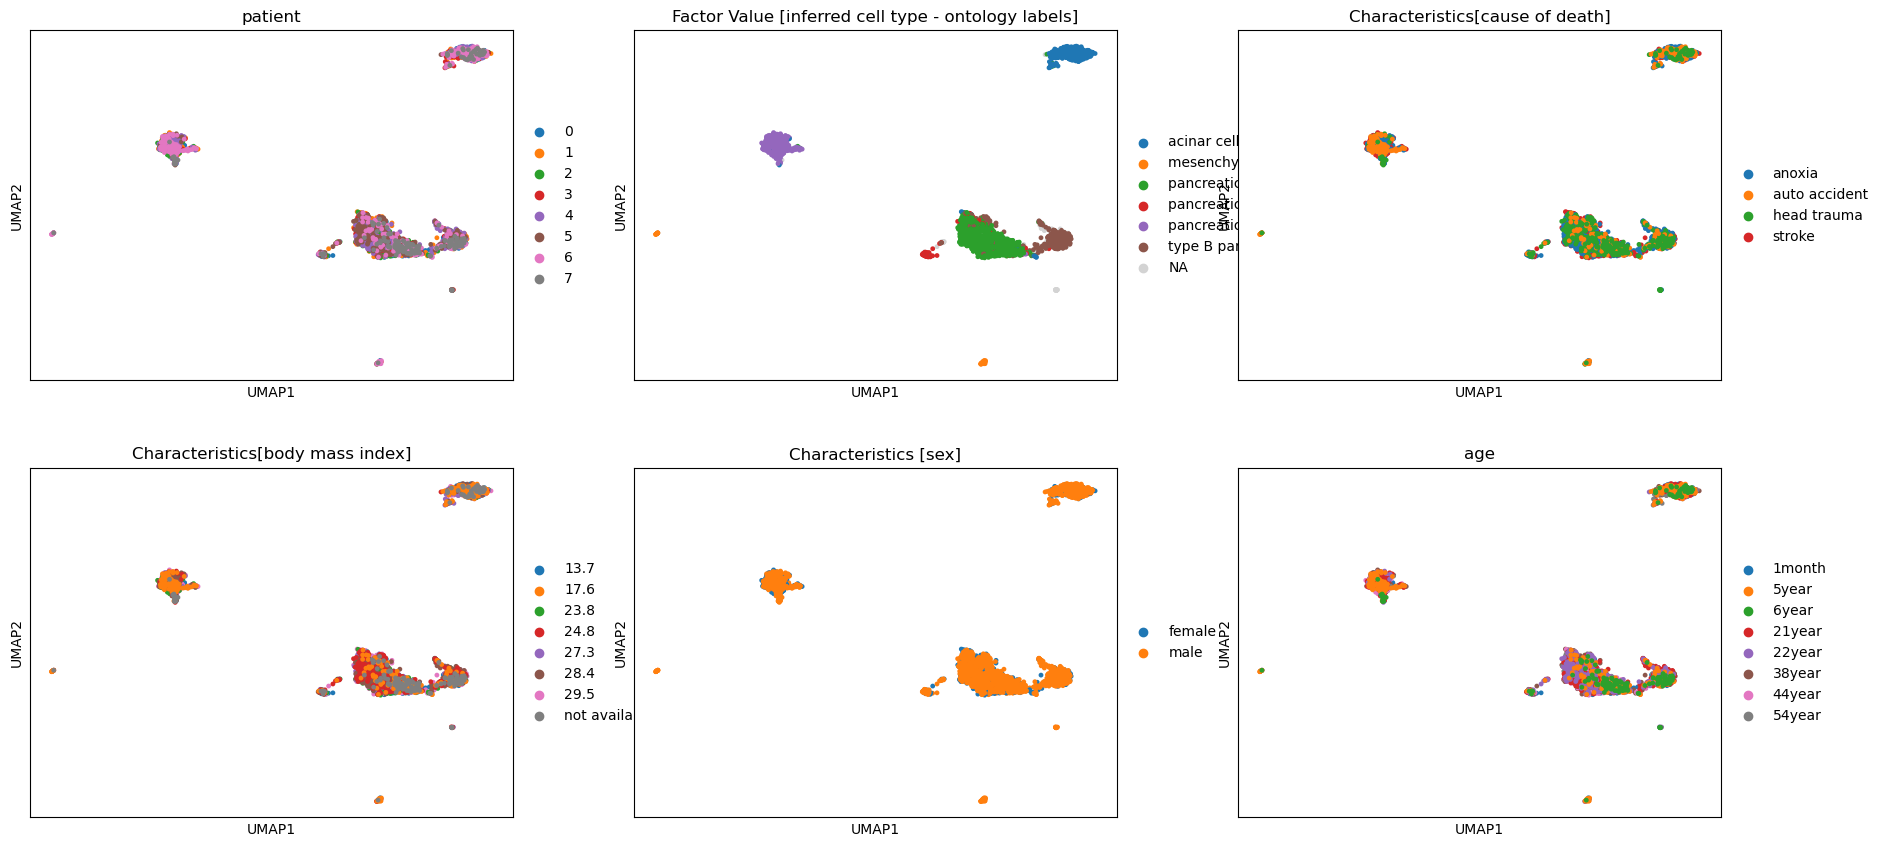

In [21]:
sc.pl.umap(harmony, color=["patient",
                         "Factor Value [inferred cell type - ontology labels]",
                         "Characteristics[cause of death]",
                         "Characteristics[body mass index]",
                         "Characteristics [sex]",
                         "age"], ncols=3);

In [22]:
# # COMBAT

# combat = ad.concat(patients.values(), join="outer", label="patient")
# # Let's transfer the metadata from a previous file:
# combat.var = patients["scRSq01"].var[["gene_names", "mitochondrial", "ribosomal"]].copy()
# sc.pp.calculate_qc_metrics(combat, inplace=True)

# sc.pp.combat(combat, key="patient")

# sc.pp.highly_variable_genes(combat)

# sc.pp.highly_variable_genes(combat, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key="patient")
# sc.pp.normalize_per_cell(combat, counts_per_cell_after=None)
# sc.pp.log1p(combat)
# sc.pp.pca(combat, n_comps=50, use_highly_variable=True, chunked=True)
# sc.pp.neighbors(combat, n_neighbors=10, n_pcs=40, metric="cosine")
# sc.tl.umap(combat, min_dist=0.2)

# sc.pl.umap(combat, color=["patient",
#                          "Factor Value [inferred cell type - ontology labels]",
#                          "Characteristics[cause of death]",
#                          "Characteristics[body mass index]",
#                          "Characteristics [sex]",
#                          "age"], ncols=3);

# Scanorama

In [23]:
scanorama = ad.concat(patients.values(), join="outer", label="patient")
# Let's transfer the metadata from a previous file:
scanorama.var = patients["scRSq01"].var[["gene_names", "mitochondrial", "ribosomal"]].copy()
sc.pp.calculate_qc_metrics(scanorama, inplace=True)

In [24]:
sc.pp.normalize_per_cell(scanorama, counts_per_cell_after=None)
sc.pp.log1p(scanorama)
sc.pp.highly_variable_genes(scanorama, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.pca(scanorama, n_comps=50, use_highly_variable=True, chunked=True)

In [25]:
sc.external.pp.scanorama_integrate(scanorama, "patient")

[[0.         0.40271493 0.29411765 0.67420814 0.14027149 0.64253394
  0.40723982 0.24719101]
 [0.         0.         0.53818182 0.54135338 0.23593074 0.30742049
  0.74233129 0.51123596]
 [0.         0.         0.         0.52       0.83636364 0.43636364
  0.12269939 0.15730337]
 [0.         0.         0.         0.         0.26441352 0.88339223
  0.58270677 0.37078652]
 [0.         0.         0.         0.         0.         0.44522968
  0.13190184 0.15730337]
 [0.         0.         0.         0.         0.         0.
  0.48056537 0.19662921]
 [0.         0.         0.         0.         0.         0.
  0.         0.96629213]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]
Processing datasets 6 <=> 7
Processing datasets 3 <=> 5
Processing datasets 2 <=> 4
Processing datasets 1 <=> 6
Processing datasets 0 <=> 3
Processing datasets 0 <=> 5
Processing datasets 3 <=> 6
Processing datasets 1 <=> 3
Processing datasets 1 <=> 2
Processing datasets 2 <=> 3

In [26]:
sc.pp.neighbors(scanorama, use_rep="X_scanorama")
sc.tl.umap(scanorama, min_dist=0.2)

/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax

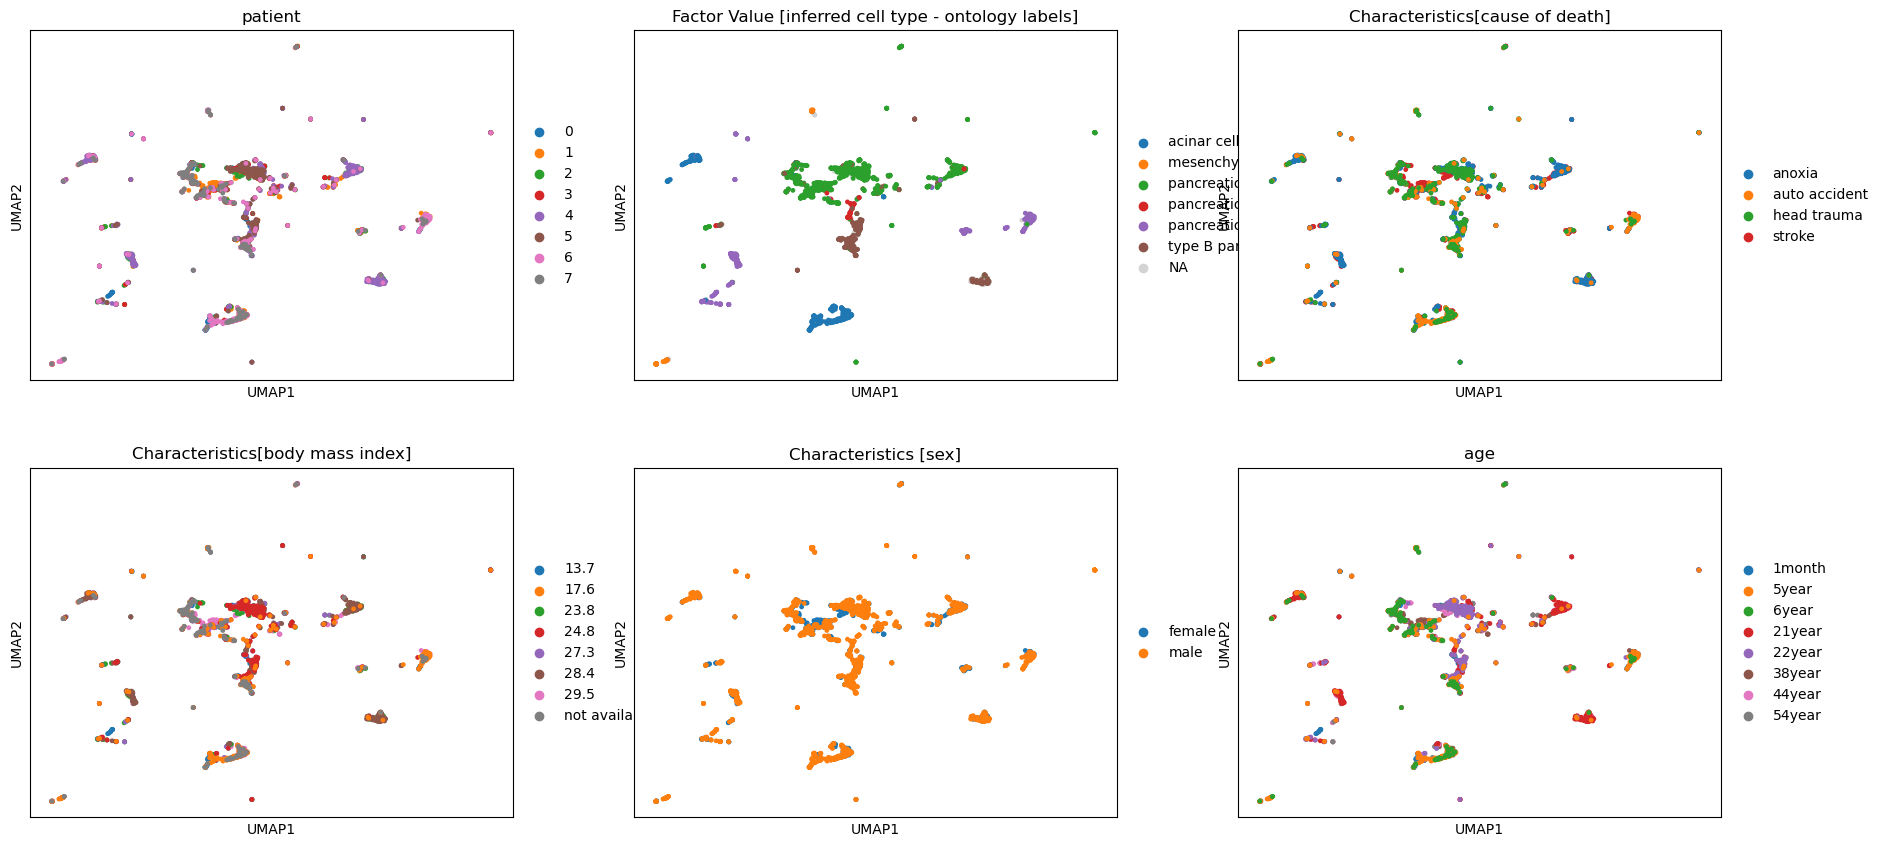

In [27]:
sc.pl.umap(scanorama, color=["patient",
                         "Factor Value [inferred cell type - ontology labels]",
                         "Characteristics[cause of death]",
                         "Characteristics[body mass index]",
                         "Characteristics [sex]",
                         "age"], ncols=3);